## Using SAS DLPy to Perform Multi-step-ahead Forecasting

In the "SineCurve_TimeSeries_Onestep_ahead_Forecasting.ipynb" example, we showed timeseries forecasting with one-step-ahead forecasting, with `model.score` function. In this example, we demonstrate:

1. Difference between one-step-ahead forecast and multi-step-ahead forecast, and their applications.
2. How to do multi-step-ahead forecast with `model.forecast`

### 1. One-step-ahead forecasting vs. Multi-step-ahead forecasting

1. **One-step-ahead forecasting**: After model training, one-step-ahead forecasting means we use observed values at previous time steps as input to predict the response value at the immediate next time step. This can be achieved by `model.predict(test_table)` or `model.score(test_table)` function, where each row in `test_table` contains the **observed values at previous time steps** as the input, and generate a column named `_DL_Pred_`, which contains the predicted values given the input vectors. In many forecasting scenarios, this predicted value is often referred as one-step-ahead forecast. 
<br>
<br>
2. **Multi-step-ahead forecasting**: More commonly in forecasting practices, we need to forecast multiple time steps ahead. In another word, we use $[Y_{t-l+1},Y_{t-l+2},\cdots,Y_{t}]$ to forecast $[Y_{t+1},Y_{t+2},\cdots,Y_{t+h}]$, where $l$ is the subsequence length (`seq_len` argument in `TimeseriesTable.prepare_subsequences` function), which is also length of the history you use in your model to predict next time step. $h$ is the forecasting horizon. We cannot directly use `model.predict(test_table)` or `model.score(test_table)` here, since we need $Y_{t+h-1}$ to predict $Y_{t+h}$, yet $Y_{t+h-1}$ is not an observed value and we need to predict $Y_{t+h-1}$ first. In the following part of this example, we will show how to use `model.forecast()` to achieve this. 

 <img src="./datasources/Multi-step-ahead.png">

### 2. Multi-step-ahead forecast with DLPy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import swat.cas.datamsghandlers as dmh
from swat import *
import dlpy
from dlpy import Sequential
from dlpy.layers import * 
from dlpy.model import Optimizer, AdamSolver, Sequence
from dlpy.timeseries import plot_timeseries
%matplotlib inline
conn = CAS('your_host', port_number)

### 2.1 Timeseries with no covariates.

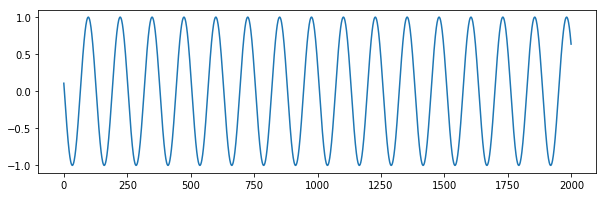

In [2]:
np.random.seed(2)

T = 20
L = 2000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / T).astype('float64')

one_sine = pd.Series(data[0,:], name='sine')

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(one_sine)

<h3>Preprocessing</h3>

Preprocessing timeseries is similar to the example "SineCurve_TimeSeries_Onestep_Ahead_Forecasting.ipynb". Please see the detailed walk-through there. 

In [3]:
# Load table from pandas series
sine_tbl = dlpy.TimeseriesTable.from_pandas(conn, one_sine)

# Formatting timeseries
sine_tbl.timeseries_formatting(timeid='index',timeseries='sine')

# Accumulate timeseries
sine_tbl.timeseries_accumlation(acc_interval='OBS')

# Make timeseries into subsequences
sine_tbl.prepare_subsequences(seq_len=25, target='sine')

# Split time series into train and test
validation_start = 1550
testing_start = 1750

train_tbl, valid_tbl, test_tbl = sine_tbl.timeseries_partition(validation_start=validation_start, testing_start=testing_start)

NOTE: Timeseries formatting is completed.
NOTE: Added action set 'timeData'.
NOTE: Timeseries are accumulated to the frequency of OBS
NOTE: timeseries subsequences are prepared with subsequence length = 25
NOTE: Training set has 1525 observations
NOTE: Validation set has 200 observations
NOTE: Testing set has 250 observations


<h3>Building the model</h3>

NOTE: Input layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


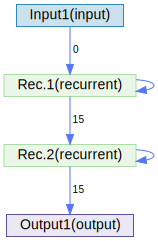

In [4]:
model1 = Sequential(conn, model_table='lstm_rnn')

model1.add(InputLayer(std='STD'))
model1.add(Recurrent(rnn_type='LSTM', output_type='samelength', n=15, reversed_=False))
model1.add(Recurrent(rnn_type='LSTM', output_type='encoding',  n=15, reversed_=False))
model1.add(OutputLayer(act='IDENTITY'))

model1.plot_network()

<h3>Specify the training options and train</h3>

NOTE: Training from scratch.


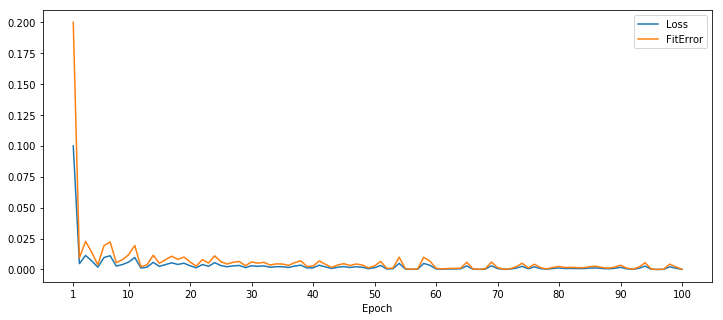

In [5]:
optimizer = Optimizer(algorithm=AdamSolver(), mini_batch_size=4, seed=1234, max_epochs=100)
# The attribute sequence_opt of train_tbl contains all the essential sequence modeling information
# It includes: input_length, target_length, token_size
seq_spec  = Sequence(**train_tbl.sequence_opt)
result = model1.fit(train_tbl, optimizer=optimizer, sequence=seq_spec, valid_table=valid_tbl, **train_tbl.inputs_target)
model1.plot_training_history(tick_frequency=10)

<h3>Forecasting for 250 steps</h3>

`horizon=250` specifies the forecasting horizon (or how many steps ahead). Note that if we don't specify the `test_data`, the forecast will automatically be extended from the latest observation of the training data. If validation data is provided during training, the forecast will be extended from the latest observation of training + validation combined.  

In [6]:
forecast_tbl = model1.forecast(horizon=250)

NOTE: test_table is None, extending forecast from training/validation data


<h3>Plotting the result</h3>

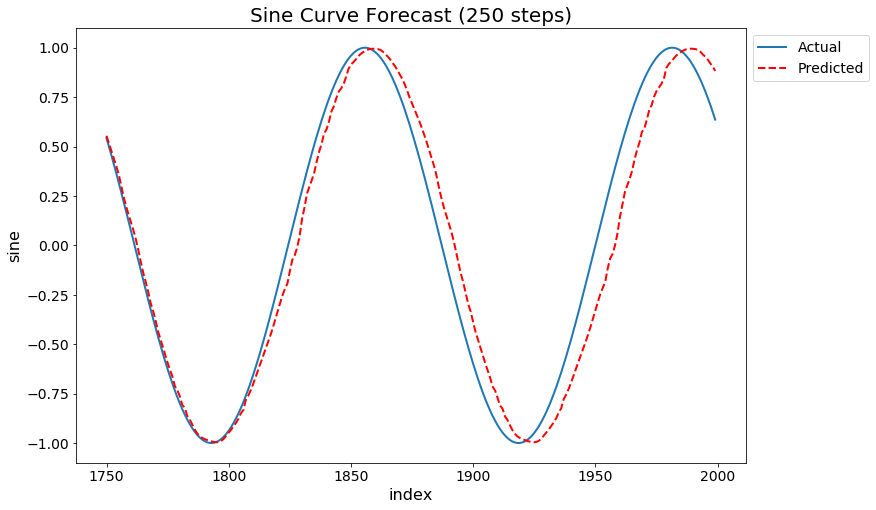

In [7]:
figure1 = plot_timeseries(test_tbl, 'index', 'sine', label='Actual',  figsize=(12, 8), 
                        xlabel='index', linewidth=2, title='Sine Curve Forecast (250 steps)')

figure2 = plot_timeseries(forecast_tbl, 'index', '_DL_Pred_', label='Predicted', figure = figure1, linestyle='--', color='red',
                        linewidth=2)

In [8]:
from dlpy.metrics import mean_squared_error, explained_variance_score
mse = mean_squared_error(test_tbl.sine, forecast_tbl._DL_Pred_, id_vars='index')
evs = explained_variance_score(test_tbl.sine, forecast_tbl._DL_Pred_, id_vars='index')

In [9]:
print('Root Mean Squared Error is {:.6}'.format(mse))
print('Explained Variance Score is {:.6}'.format(evs))

Root Mean Squared Error is 0.0255069
Explained Variance Score is 0.950167


### 2.2 Timeseries with covariates.

We can also use `model.forecast` if covariates are present and provided in the `test_table`. In the following example, we show we use another sine curve to predict the target sine curve. 

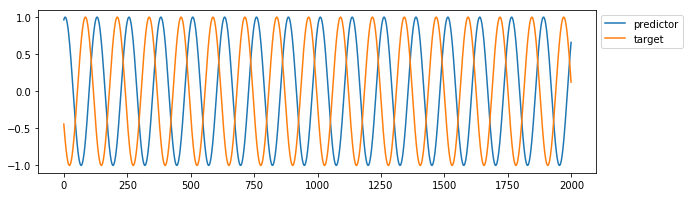

In [10]:
np.random.seed(3)

T = 20
L = 2000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / T).astype('float64')

two_sines = pd.DataFrame(data[:2,:].T, columns=['predictor','target'])
two_sines = two_sines.reset_index()

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(two_sines.loc[:,'predictor'], label='predictor')
ax.plot(two_sines.loc[:,'target'], label='target')
ax.legend(loc='best', bbox_to_anchor=(1, 1))

<h3>Preprocessing</h3>

Preprocessing timeseries is similar to the example "SineCurve_TimeSeries_Onestep_Ahead_Forecasting.ipynb". Please see the detailed walk-through there. 

In [11]:
# Load table from pandas series
sine_tbl = dlpy.TimeseriesTable.from_pandas(conn, two_sines)

# Formatting timeseries, specify both 'predictor' and 'target' as both timeseries are used
sine_tbl.timeseries_formatting(timeid='index',timeseries=['predictor','target'])

# Accumulate timeseries
sine_tbl.timeseries_accumlation(acc_interval='OBS')

# Make timeseries into subsequences. Use['predictor','target'] to predict 'target'.
sine_tbl.prepare_subsequences(seq_len=25, target='target', predictor_timeseries=['predictor','target'])

# Split time series into train and test
validation_start = 1550
testing_start = 1750

train_tbl, valid_tbl, test_tbl = sine_tbl.timeseries_partition(validation_start=validation_start, testing_start=testing_start)

NOTE: Timeseries formatting is completed.
NOTE: Added action set 'timeData'.
NOTE: Timeseries are accumulated to the frequency of OBS
NOTE: timeseries subsequences are prepared with subsequence length = 25
NOTE: Training set has 1525 observations
NOTE: Validation set has 200 observations
NOTE: Testing set has 250 observations


<h3>Building the model</h3>

NOTE: Input layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


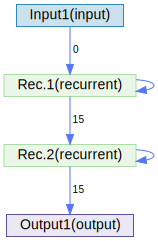

In [12]:
model1 = Sequential(conn, model_table='lstm_rnn')

model1.add(InputLayer(std='STD'))
model1.add(Recurrent(rnn_type='LSTM', output_type='samelength', n=15, reversed_=False))
model1.add(Recurrent(rnn_type='LSTM', output_type='encoding',  n=15, reversed_=False))
model1.add(OutputLayer(act='IDENTITY'))

model1.plot_network()

<h3>Specify the training options and train</h3>

NOTE: Training based on existing weights.


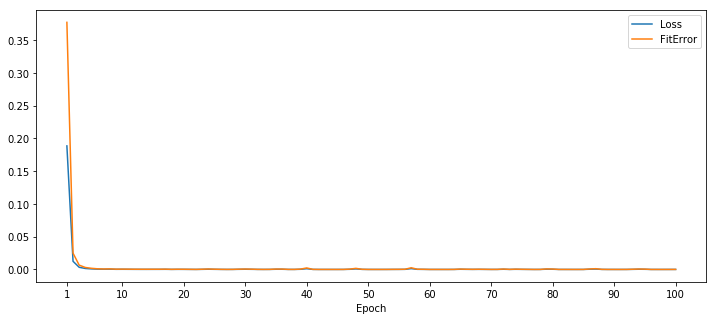

In [13]:
optimizer = Optimizer(algorithm=AdamSolver(), mini_batch_size=4, seed=1234, max_epochs=100)
# The attribute sequence_opt of train_tbl contains all the essential sequence modeling information
# It includes: input_length, target_length, token_size
seq_spec  = Sequence(**train_tbl.sequence_opt)
result = model1.fit(train_tbl, optimizer=optimizer, sequence=seq_spec, valid_table=valid_tbl, **train_tbl.inputs_target)
model1.plot_training_history(tick_frequency=10)

<h3>Forecasting for 250 steps</h3>

`horizon=250` specifies the forecasting horizon (or how many steps ahead). This time we specified the `test_table=test_tbl`, so the forecast will start with the first observation in `test_tbl`. It will use the 'predictor' timeseries in `test_tbl` as deterministic input variables (that we can obtain prior to making forecast), together with previous time steps of the 'target' series to predict the 'target' value in the next time step. The predicted values are then being used for predicting later time steps. This procedure repeats for 250 times internally to give the `horizon=250` forecast. 

In [14]:
forecast_tbl = model1.forecast(test_table=test_tbl, horizon=250)

<h3>Plotting the result</h3>

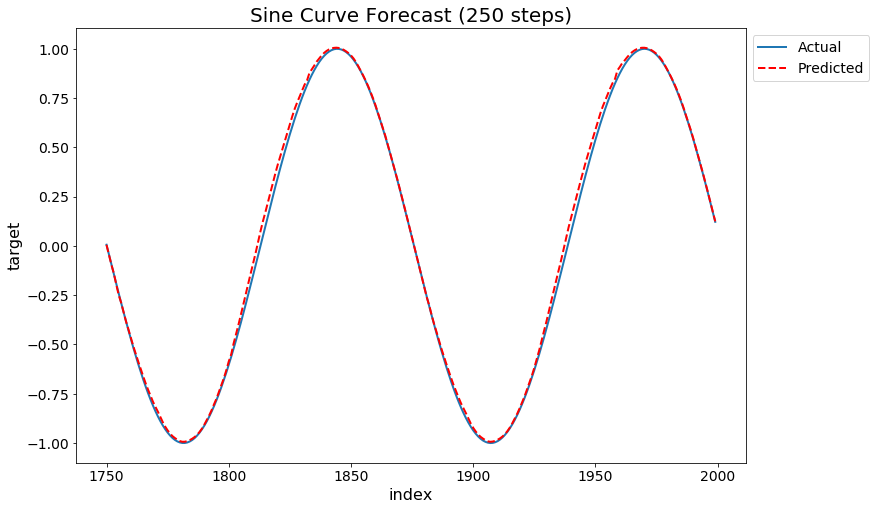

In [15]:
figure1 = plot_timeseries(test_tbl, 'index', 'target', label='Actual',  figsize=(12, 8), 
                        xlabel='index', linewidth=2, title='Sine Curve Forecast (250 steps)')

figure2 = plot_timeseries(forecast_tbl, 'index', '_DL_Pred_', label='Predicted', figure = figure1, linestyle='--', color='red',
                        linewidth=2)

In [16]:
mse = mean_squared_error(test_tbl['target'], forecast_tbl._DL_Pred_, id_vars='index')
evs = explained_variance_score(test_tbl['target'], forecast_tbl._DL_Pred_, id_vars='index')

In [17]:
print('Root Mean Squared Error is {:.6}'.format(mse))
print('Explained Variance Score is {:.6}'.format(evs))

Root Mean Squared Error is 0.000843466
Explained Variance Score is 0.999081
